In [2]:
import os
import random
import numpy as np
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.models import regnet_y_400mf, RegNet_Y_400MF_Weights


In [4]:
import os
import torch
from PIL import Image, UnidentifiedImageError
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

# Path to dataset folder
data_dir = 'dataset/ex'

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

# Custom dataset class
class WorkoutDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        self.class_to_idx = {cls: i for i, cls in enumerate(sorted(os.listdir(root_dir)))}

        for cls in self.class_to_idx:
            class_path = os.path.join(root_dir, cls)
            for file in os.listdir(class_path):
                filepath = os.path.join(class_path, file)
                if not os.path.isfile(filepath):  # 🚨 skip folders
                    continue
                try:
                    with Image.open(filepath) as img:
                        img.verify()
                    self.image_paths.append(filepath)
                    self.labels.append(self.class_to_idx[cls])
                except (UnidentifiedImageError, OSError):
                    pass

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Create dataset and split 70/20/10
dataset = WorkoutDataset(data_dir, transform)

total = len(dataset)
train_size = int(0.7 * total)
val_size = int(0.2 * total)
test_size = total - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size],
                                         generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# Save and print class names
classes = sorted(os.listdir(data_dir))

print("✅ Classes found in dataset:")
for idx, cls in enumerate(classes):
    print(f"{idx}: {cls}")

# Optional: Save to file
# with open("classes.txt", "w") as f:
#     for idx, cls in enumerate(classes):
#         f.write(f"{idx}: {cls}\n")


✅ Classes found in dataset:
0: barbell biceps curl
1: bench press
2: chest fly machine
3: deadlift
4: decline bench press
5: hammer curl
6: hip thrust
7: incline bench press
8: lat pulldown
9: lateral raises
10: leg extension
11: leg raises
12: plank
13: pull up
14: push up
15: romanian deadlift
16: russian twist
17: shoulder press
18: squat
19: t bar row
20: tricep dips
21: tricep pushdown


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = regnet_y_400mf(weights=RegNet_Y_400MF_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, len(classes))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [6]:
num_epochs = 10
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(num_epochs):
    # Train
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # Validate
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / total
    val_acc = correct / total
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")


Epoch 1/10 | Train Loss: 0.4108 Acc: 0.8878 | Val Loss: 0.1480 Acc: 0.9567
Epoch 2/10 | Train Loss: 0.1280 Acc: 0.9613 | Val Loss: 0.2098 Acc: 0.9444
Epoch 3/10 | Train Loss: 0.1009 Acc: 0.9704 | Val Loss: 0.1714 Acc: 0.9581
Epoch 4/10 | Train Loss: 0.0573 Acc: 0.9826 | Val Loss: 0.1715 Acc: 0.9556
Epoch 5/10 | Train Loss: 0.0933 Acc: 0.9737 | Val Loss: 0.0941 Acc: 0.9736
Epoch 6/10 | Train Loss: 0.0520 Acc: 0.9833 | Val Loss: 0.1276 Acc: 0.9693
Epoch 7/10 | Train Loss: 0.0485 Acc: 0.9857 | Val Loss: 0.1311 Acc: 0.9722
Epoch 8/10 | Train Loss: 0.0706 Acc: 0.9802 | Val Loss: 0.0669 Acc: 0.9838
Epoch 9/10 | Train Loss: 0.0549 Acc: 0.9860 | Val Loss: 0.1102 Acc: 0.9661
Epoch 10/10 | Train Loss: 0.0151 Acc: 0.9956 | Val Loss: 0.0614 Acc: 0.9852


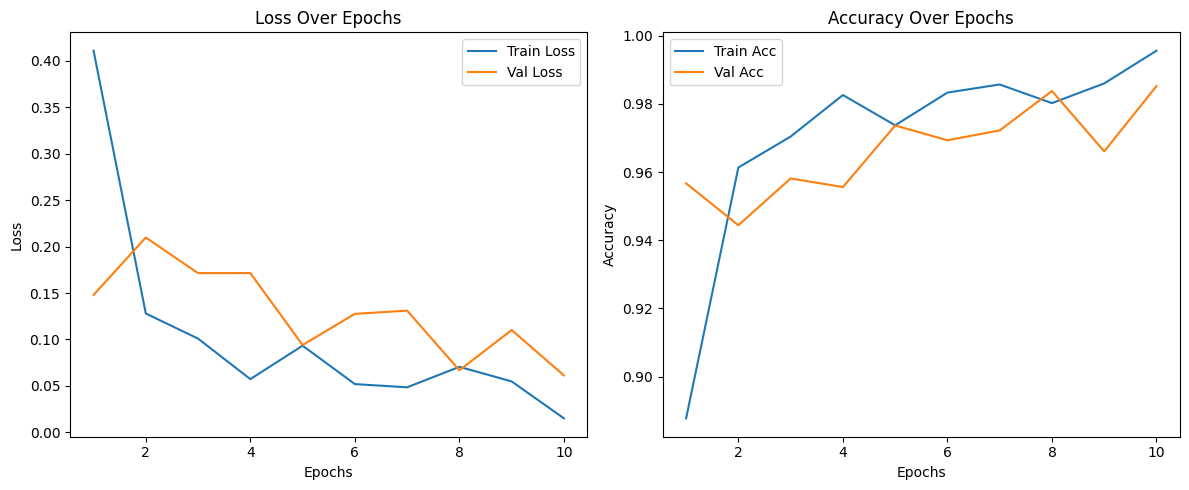

In [7]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list, label='Train Loss')
plt.plot(epochs, val_loss_list, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_list, label='Train Acc')
plt.plot(epochs, val_acc_list, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


✅ Test Accuracy: 0.9784


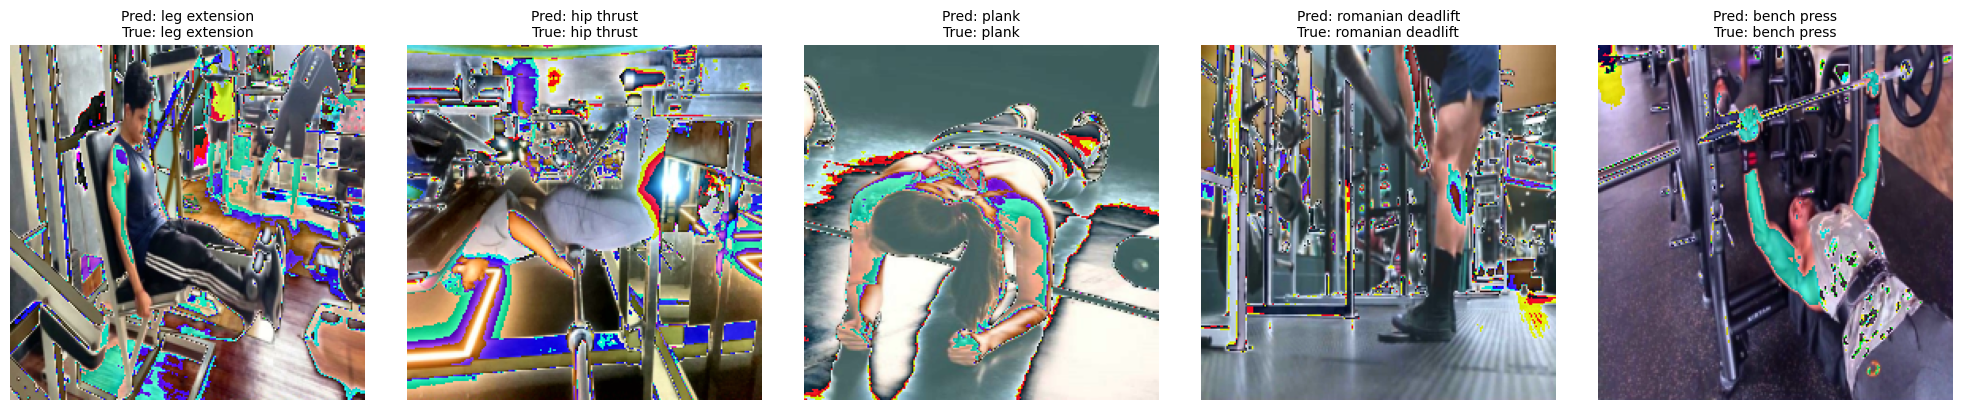

In [8]:
import random
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

# --- A. Evaluate Accuracy on Full Test Set ---
def evaluate_accuracy(data_loader, name="Test"):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    print(f"✅ {name} Accuracy: {acc:.4f}")
    return acc

test_accuracy = evaluate_accuracy(test_loader, "Test")

# --- B. Inference on x random test samples (No drawing, just display) ---
def infer_random_test_images(x=5):
    model.eval()
    indices = random.sample(range(len(test_ds)), x)

    plt.figure(figsize=(4 * x, 4))  # wide enough for x images

    for i, idx in enumerate(indices):
        image, label = test_ds[idx]
        input_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            _, pred = torch.max(output, 1)

        predicted_class = classes[pred.item()]
        true_class = classes[label]

        img = F.to_pil_image((image * 255).byte())

        plt.subplot(1, x, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Pred: {predicted_class}\nTrue: {true_class}", fontsize=10)

    plt.tight_layout()
    plt.show()

infer_random_test_images(x=5)


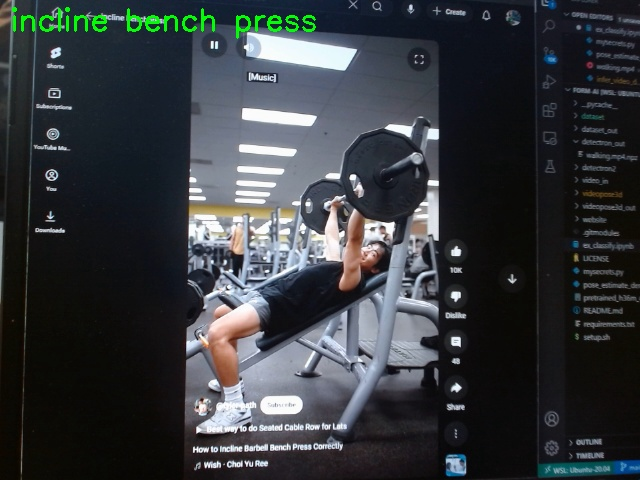

🛑 Stream ended.


In [ ]:
import cv2
import time
import torch
from IPython.display import display, clear_output, Image as IPImage
from torchvision import transforms
from PIL import Image 
from classification.mysecrets import WEB_ADRESS

# 🔧 Settings
X_SECONDS = 60
FR_SKIP = 5  # Run inference every 5 frames
STREAM_URL = WEB_ADRESS
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🧠 Preprocessing (must match your model's training)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, std=[0.5]*3),
])

# 📷 Start stream
cap = cv2.VideoCapture(STREAM_URL)

if not cap.isOpened():
    print("❌ Could not open webcam stream.")
    cap.release()
else:
    print("✅ Displaying live webcam feed with prediction...")
    start_time = time.time()
    frame_count = 0
    label = "..."  # Initial label before inference

    while time.time() - start_time < X_SECONDS:
        ret, frame = cap.read()
        if not ret:
            continue

        frame_count += 1

        # Only run inference every FR_SKIP frames
        if frame_count % FR_SKIP == 0:
            img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_img = Image.fromarray(img_rgb)
            input_tensor = preprocess(pil_img).unsqueeze(0).to(device)

            model.eval()
            with torch.no_grad():
                output = model(input_tensor)
                _, pred = torch.max(output, 1)
                label = classes[pred.item()]

        # Add prediction label to image
        cv2.putText(frame, f"{label}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Encode and display in Jupyter
        _, jpeg = cv2.imencode('.jpg', frame)
        clear_output(wait=True)
        display(IPImage(data=jpeg.tobytes()))

    cap.release()
    print("🛑 Stream ended.")




In [9]:
# Save model
torch.save(model.state_dict(), "models/model.pth")

# Save class names
with open("classes.txt", "w") as f:
    for name in classes:
        f.write(f"{name}\n")
